# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


Visualize the maze

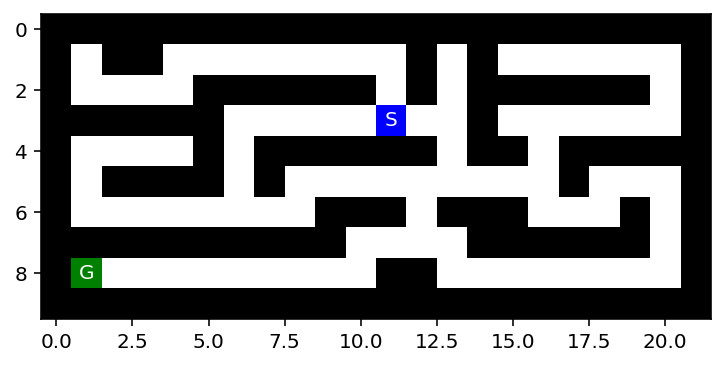

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show_maze(maze)


Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))
print(maze)

Start location: (3, 11)
Goal location: (8, 1)
[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' 'S' ' ' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' 'X' ' ' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X'
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' 'X' ' ' 'X' 'X' 'X' ' ' ' '
  ' ' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']]


## Tree structure

Implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73):

In [5]:
def heuristic(current_node, end_goal): ## moved here for ease of access: will show up later though.
    dist_x = abs(current_node.pos[0] - end_goal[0])
    dist_y = abs(current_node.pos[1] - end_goal[1])
    return dist_x + dist_y

class Node:
    end_node = None
    
    @staticmethod
    def set_final(final):
        end_node = final
        
        
        
    def __init__(self, pos, parent, action, cost, depth = 0, node_type=0 ):
        '''
        So this got a little more complex and messy than it should have. I ran out of time to clean it up.
        a lot of this may be redundant or a little tedious:
    
        depth     -- originally meant to be different from cost. Ended up being the same
        node_type -- Used to specify priority. 0 = regular node; 1 = GBFS use only h(x); 2 = A* use h(x) + cost
    
        '''
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.depth = depth
        self.children = []
        self.node_type = node_type
    
  
        
    def add_child(self, child_node):    # adds child to children list
        self.children.append(child_node)
        
    def set_type(self, n_type):          #  sets node_type
        self.node_type = n_type
    
    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"
    
    def __eq__(self, r_node):
        if isinstance(r_node, Node): 
            return self.pos == r_node.pos
        return False
    
    
  
    def __lt__(self, r_node):
        '''
        compares based on node_type
        if node_type is 1, we do GBFS priority criteria which only uses the heuristic
        if node_type is 2, we do A* priority criteria which uses heuristic + cost
        else we just check position: however this is never used
        '''
        if isinstance(r_node, Node): # return appropriate result depending on priority criteria
            if self.node_type == 1: return heuristic(self, Node.end_node) < heuristic(r_node, Node.end_node)
            if self.node_type == 2: return heuristic(self, Node.end_node) + self.depth < heuristic(r_node, Node.end_node) + r_node.depth
            else: return self.pos < r_node.pos
        return False
        
    
    def __hash__(self):          # hash used for the set
        return hash(self.pos)
    

Example: Create the root node and append the node for going east with a cost of 1.

In [6]:
print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
print(root == node2.parent)
print()
print("Note that the root note is safe from garbage collection as long as we have a reference in node2") 
root = None
print(root)
print("parent of node2 (reference): ", repr(node2.parent))
print()
print("Once we release node2, the whole tree is deleted.")
node2 = None


Create root node
root: Node - pos = (0, 0); parent = None; action = None; cost = 0
root (reference): <__main__.Node object at 0x7f1231b07df0>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); parent = <__main__.Node object at 0x7f1231b07df0>; action = E; cost = 1
parent of node2:  Node - pos = (0, 0); parent = None; action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x7f1231b07df0>
True

Note that the root note is safe from garbage collection as long as we have a reference in node2
None
parent of node2 (reference):  <__main__.Node object at 0x7f1231b07df0>

Once we release node2, the whole tree is deleted.


# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

* Initial state = Starting square/node in the maze
* Actions = North, South, East, West
* Transition = Explore/move to new node
* Goal State = End square/node in the maze
* Path cost = 1 cost per node/square ( without heuristics) + heuristic function with heuristics

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Note that the algorithms for BFS and DFS are very different! Make sure that DFS uses less memory by releasing nodes that are not needed anymore. Follow the pseudocode in the textbook.

In [7]:
# Some helper functions
import random
def get_neighbors(cur_node):
    '''
    grabs the coordinates of the neihbors of current node based on current node position.
    Ignores the 'X' which is a wall
    '''
    x = cur_node.pos[0]
    y = cur_node.pos[1]
    neighbors = [(x,y-1,'West'),(x+1,y,'South'),\
                 (x,y+1,'East'),(x-1,y,'North')]
    return filter(lambda pos: look(maze, (pos[0],pos[1])) not in ['X'], neighbors)

def get_node_neighbors(cur_node):
    '''
    gets coordinates by using get_neighbors.
    Creates a node based on the nodes.
    Shuffles the list to make a random order
    '''
    nodes = []
    neighbors = get_neighbors(cur_node)
    for n in neighbors:
         nodes.append(
             Node(pos    = tuple(n[0:2]), \
                  parent = cur_node, \
                  action = n[2],\
                  cost = cur_node.cost + 1,
                  depth = cur_node.depth + 1
             )
         )
    random.shuffle(nodes)
    return nodes


# --- Stuff below is just marking the maze stuff --- 
def mark(maze, collection, mark_char):
    for node in collection:
        pos = node.pos
        to_mark_node = maze[pos[0], pos[1]]
        if not to_mark_node in ['S', 'G']:
            maze[pos[0], pos[1]] = mark_char

def mark_final_path(maze, end_node):
    curr_node = end_node.parent
    while curr_node.parent != None:
        pos = curr_node.pos
        maze[pos[0],pos[1]] = 'P'
        curr_node = curr_node.parent
        

def mark_maze(maze, explored_nodes, frontier, end_node = None):
    mark(maze, frontier, 'F')
    mark(maze, explored_nodes, '.')
    if end_node != None:
        mark_final_path(maze, end_node)
    

# BFS Implementation

My implementation here is heavily following the example from the book. It simply creates the nodes as it expands them, and adds them to the frontier queue as it discovers them, then puts them in the explored set as it expands them. I made some modifications to the node class to make them hashable, as well as provided a way to compare nodes directly. Also I made some helpful functions above to help along the way.

In [8]:
# throw mazes into list to iterato through when testing
mazes = [
    'empty_maze.txt',
    'empty_2_maze.txt',
    'small_maze.txt',
    'loops_maze.txt',
    'wall_maze.txt',
    'open_maze.txt',
    'medium_maze.txt',
    'large_maze.txt'
]

In [9]:
# algorithm 	path cost 	nodes expanded 	max tree depth 	max tree size 	max frontier size
#BFS
def bfs(maze, verb = False):
    ''' Initialize the starting node and set the end goal'''
    start = Node(pos    = find_pos(maze, what = "S"),\
                 parent = None, \
                 action = None, \
                 cost   = 0)
    final_pos = find_pos(maze, what = "G")
    frontier = [start]
    explored = set()
    
    ''' Keep track of this data for comparison'''
    max_frontier = 1
    tree_depth = 0
    max_tree_size = 0
    
    
    ''' Logic is essentially from the book and pythonized
        , that is if you can call this pythonized
    '''
    while len(frontier):
        current_node = frontier.pop(0)
        explored.add(current_node)
        children = get_node_neighbors(current_node)
        for child in children:
            if not (child in explored ) and not(child in frontier):
                tree_depth = max(tree_depth, child.depth)
                if child.pos == final_pos:
                    mark_maze(maze, explored, frontier, child)
                    if(verb): show_maze(maze); print(frontier)
                    if verb: print(f'current cost:{current_node.cost}\n nodes expanded:{len(explored)}\n max_depth: {tree_depth}\n max_tree_size: {max_tree_size}\n max frontier: {max_frontier}')         
                    return (child, child.cost, len(explored), tree_depth, \
                            len(frontier) + len(explored), max_frontier)
                frontier.append(child)
                max_tree_size = max(max_tree_size, (len(frontier)) + len(explored) )
                max_frontier = max(max_frontier, len(frontier))
        mark_maze(maze, explored, frontier)
        if verb: print(f'current cost:{current_node.cost}\n nodes expanded:{len(explored)}\n max_depth: {tree_depth}\n max_tree_size: {max_tree_size}\n max frontier: {max_frontier}')         
        if verb: show_maze(maze)
        max_frontier = max(max_frontier, len(frontier))

    return None # if no solution
   

#### BFS solved Mazes

 empty_maze.txt
-------------------


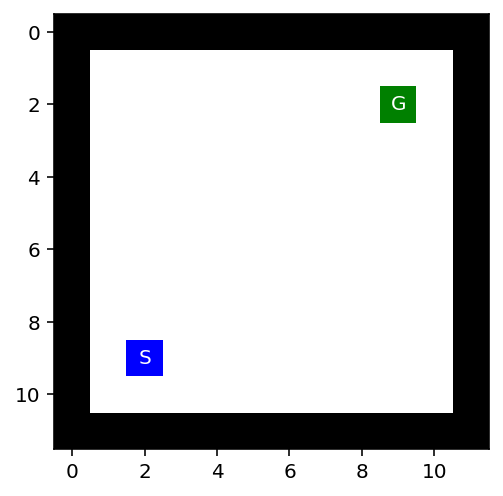

Node - pos = (2, 9); parent = <__main__.Node object at 0x7f1231aefbb0>; action = East; cost = 14
14
91
14
95
12


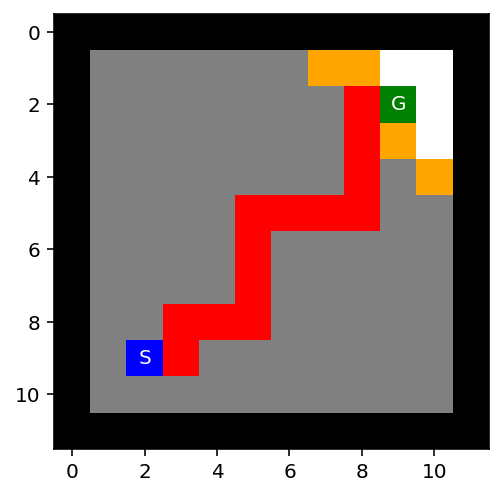

 empty_2_maze.txt
-------------------


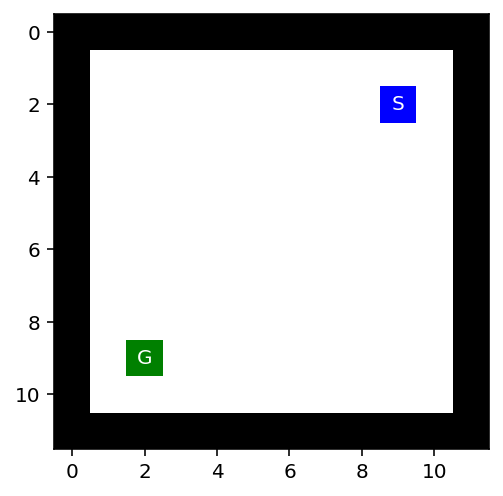

Node - pos = (9, 2); parent = <__main__.Node object at 0x7f1231783ca0>; action = West; cost = 14
14
92
14
95
12


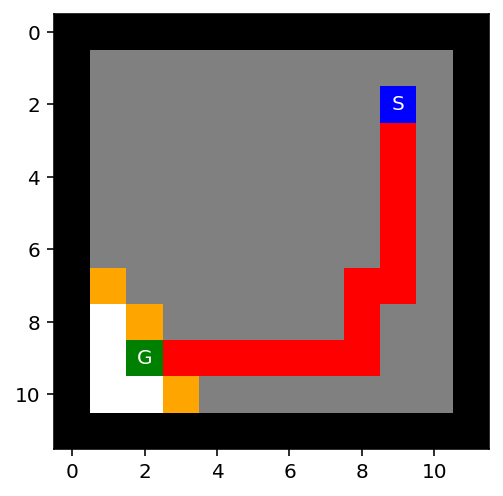

 small_maze.txt
-------------------


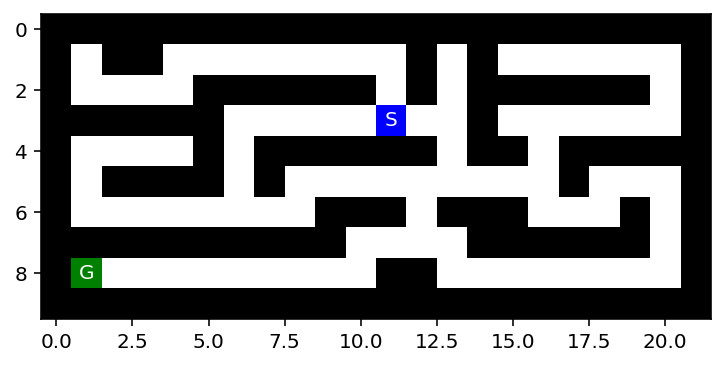

Node - pos = (8, 1); parent = <__main__.Node object at 0x7f12316c8d30>; action = West; cost = 19
19
89
19
91
9


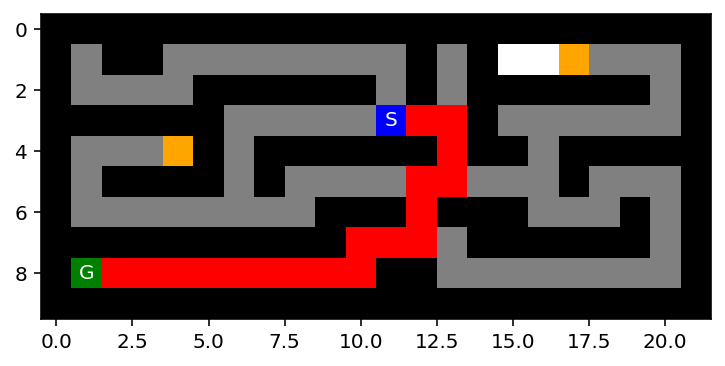

 loops_maze.txt
-------------------


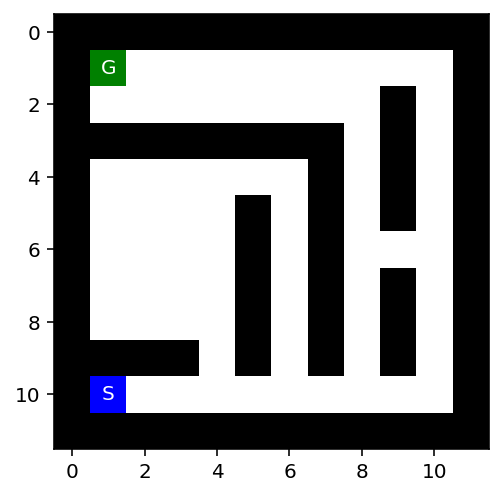

Node - pos = (1, 1); parent = <__main__.Node object at 0x7f12318d73a0>; action = West; cost = 23
23
70
23
71
8


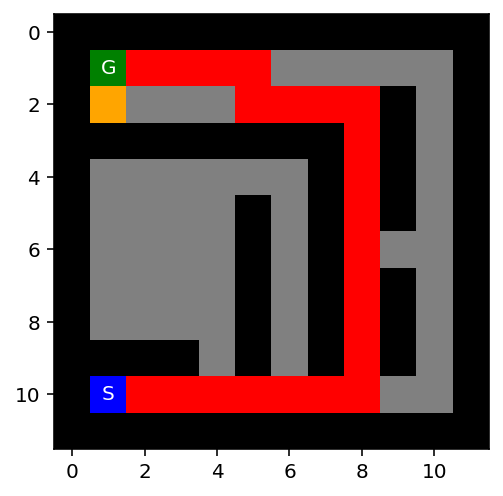

 wall_maze.txt
-------------------


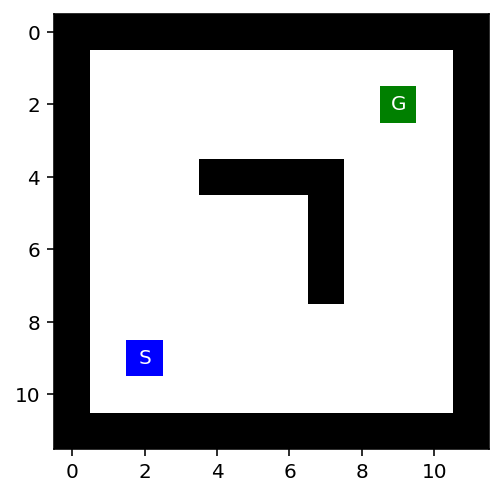

Node - pos = (2, 9); parent = <__main__.Node object at 0x7f12317f74c0>; action = North; cost = 14
14
85
14
88
10


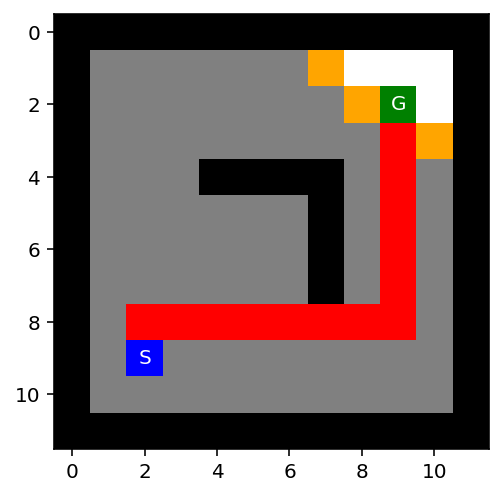

 open_maze.txt
-------------------


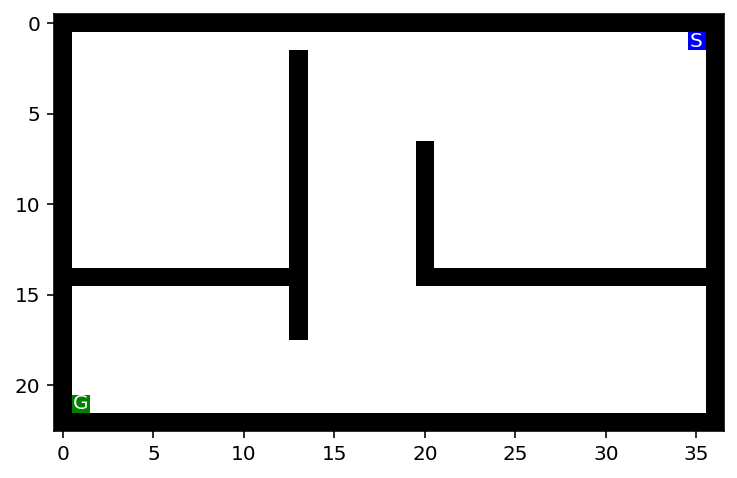

Node - pos = (21, 1); parent = <__main__.Node object at 0x7f1231a743a0>; action = West; cost = 54
54
679
54
682
25


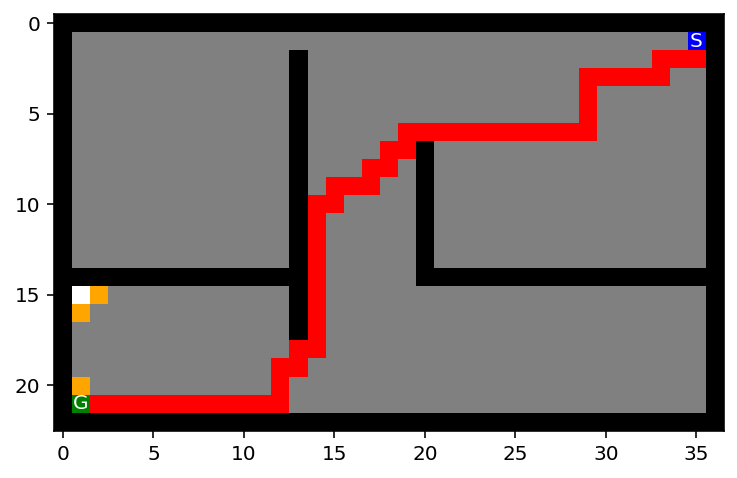

 medium_maze.txt
-------------------


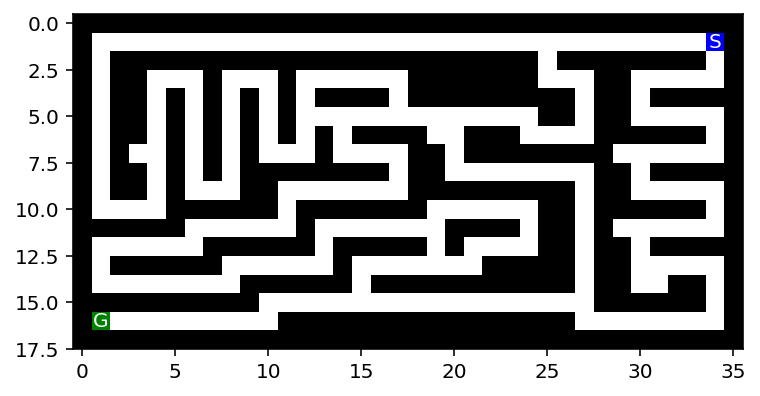

Node - pos = (16, 1); parent = <__main__.Node object at 0x7f12318f21f0>; action = West; cost = 68
68
267
68
269
8


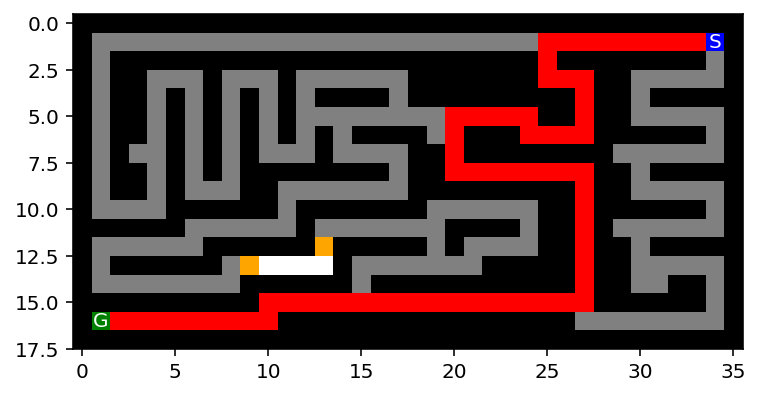

 large_maze.txt
-------------------


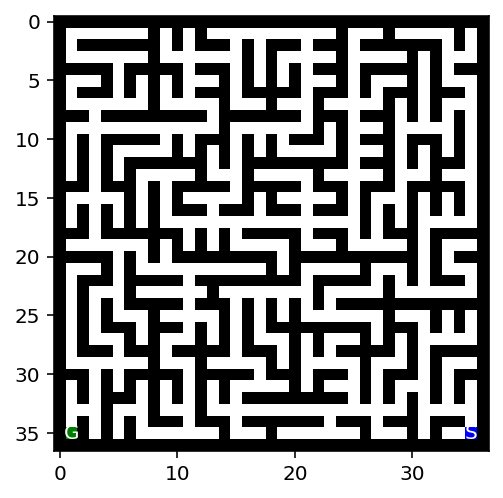

Node - pos = (35, 1); parent = <__main__.Node object at 0x7f1231663250>; action = South; cost = 210
210
618
210
621
8


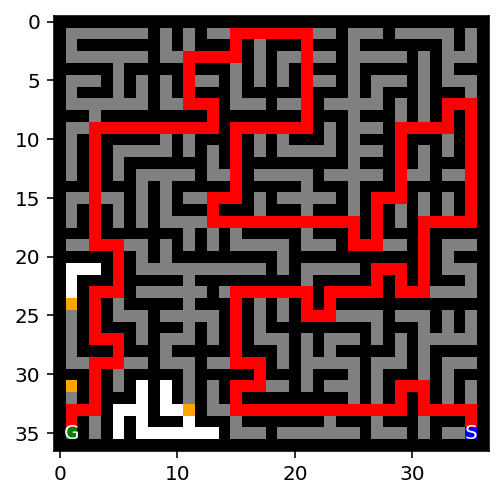

In [11]:
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' {m}\n-------------------')
    show_maze(maze)
    for i in bfs(maze):
        print (i)
    show_maze(maze)  
    f.close()

## DFS Implementation

In [12]:
# some DFS helpers
def rm_node(node_to_remove, frontier):
    for node in frontier:
        if node_to_remove in node.children:
            node.children[node.children.index(node_to_remove)] = None # remove the node.
def add_to_frontier(node, frontier):
    node.children = get_node_neighbors(node) # Need to be aware of adjacent squares
    frontier.append(node)                    # append to frontier
    
def is_valid_node(node, frontier, current_loop):
    return not (node in current_loop) and not (node in frontier) and node != None

In [13]:

# algorithm 	path cost 	nodes expanded 	max tree depth 	max tree size 	max frontier size
def dfs(maze, verb=False):
    start = Node(pos    = find_pos(maze, what = "S"),\
                 parent = None, \
                 action = None, \
                 cost   = 0)
    start.children = get_node_neighbors(start)
    final_pos = find_pos(maze, what = "G")
    frontier = [start] 
    
    ''' data stuff'''
    max_frontier = 1
    tree_depth = 0
    max_tree_size = 0
    nodes_expanded = 0
    
    current_loop = set() # saves nodes that are in the current loop
    while(len(frontier)):
        current_node = frontier[-1]     #explore last item in the frontier stack
        dead_end_node = True            # assume node is a dead end     
        current_loop.add(current_node)  # add current node into the current loop set (assuming it is not in it)
        if verb: print(current_node)    # print node if verb                
        nodes_expanded = max(nodes_expanded, len(current_loop))
        for child in current_node.children:                       # considering the children
            if is_valid_node(child,frontier,current_loop):  # not in frontier and not in current_loop
                tree_depth = max(tree_depth, child.depth)
                if child.pos == final_pos:           # if child is final position, return it         
                    mark_maze(maze,current_loop,frontier, child)
                    return (child, child.cost, nodes_expanded, tree_depth, max_tree_size, max_frontier)
                add_to_frontier(child, frontier)           # else the child will be added to the frontier
                max_tree_size = max(max_tree_size, len(frontier))
                max_frontier = max(max_frontier, len(frontier) - len(current_loop))
                dead_end_node = False      # if node has reachable children, it is not a dead end
        if verb: print(f'current cost:{current_node.cost}\n nodes expanded:{nodes_expanded}\n max_depth: {tree_depth}\n max_tree_size: {max_tree_size}\n max frontier: {max_frontier}')         
        #if verb: print(f'frontier:{len(frontier)}\ncurrentloop{len(current_loop)}')
        if dead_end_node: 
            maze[current_node.pos[0], current_node.pos[1]] = 'R'  # Purely visual. Represents removed nodes
            current_loop.remove(current_node)                   # Remove dead end node from current loop
            frontier.pop()                                      # look at next node in frontier
            rm_node(current_node, frontier)                    # Remove node from tree.
            
        mark_maze(maze, current_loop, frontier)
        if verb: show_maze(maze)
        
              


# DFS Solved mazes

 empty_maze.txt
-------------------


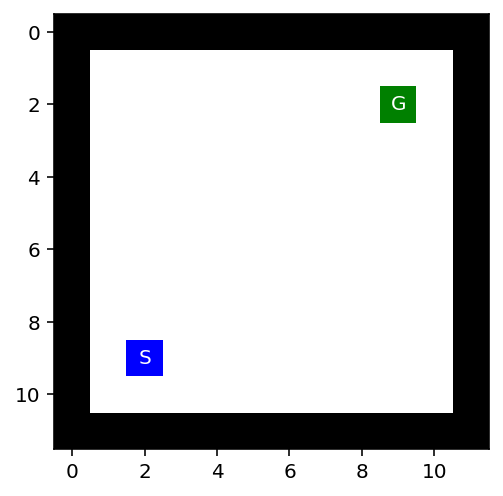

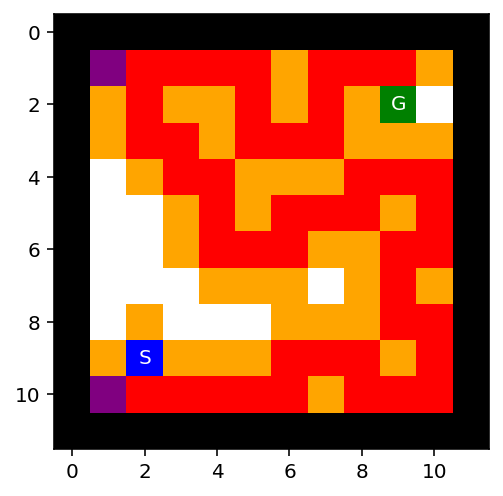

 empty_2_maze.txt
-------------------


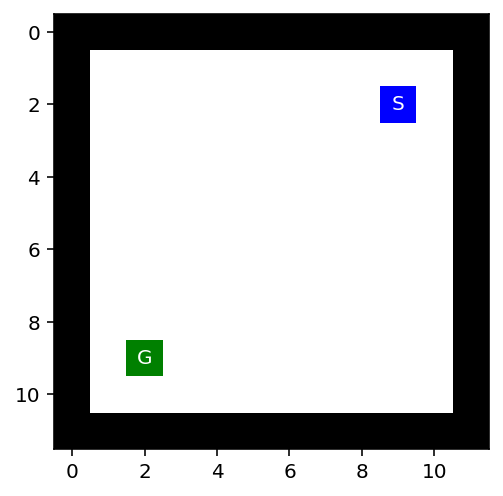

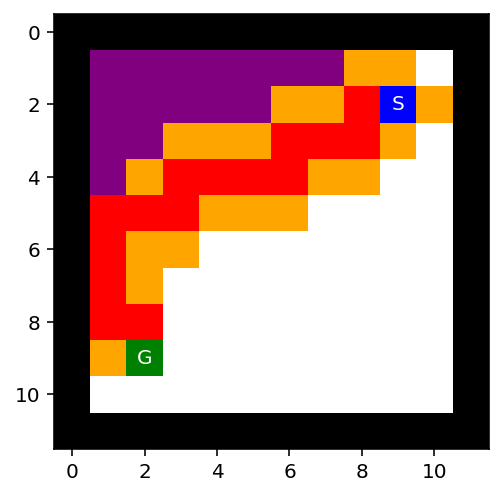

 small_maze.txt
-------------------


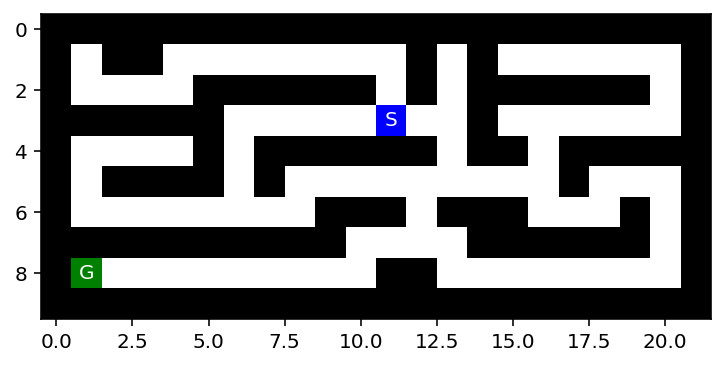

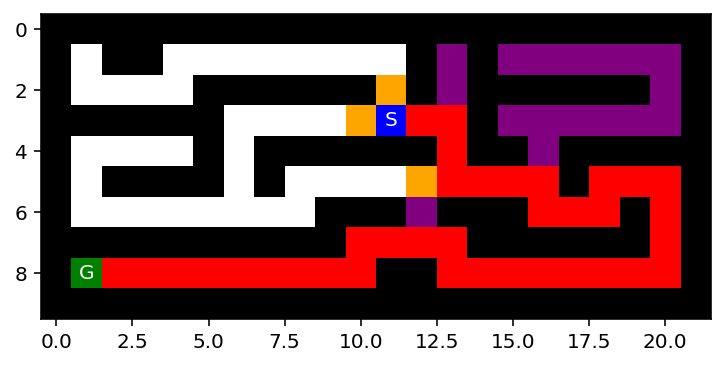

 loops_maze.txt
-------------------


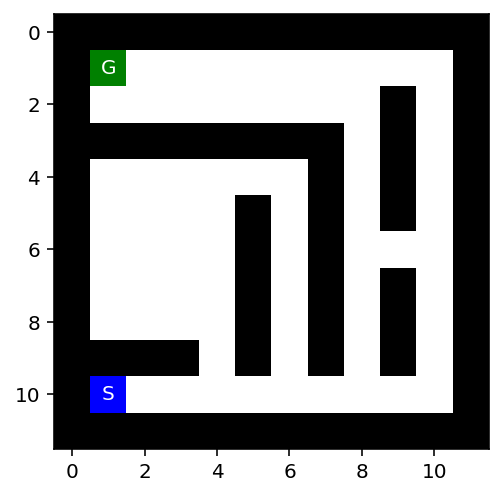

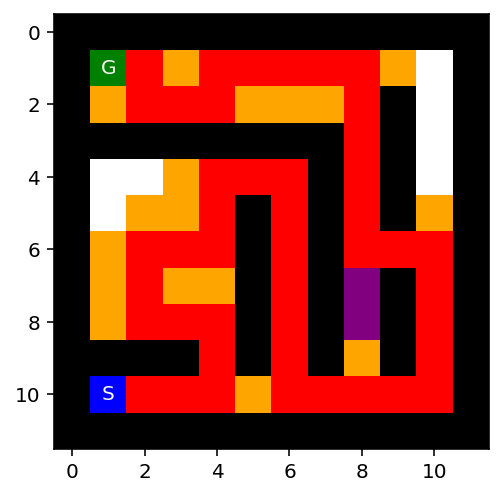

 wall_maze.txt
-------------------


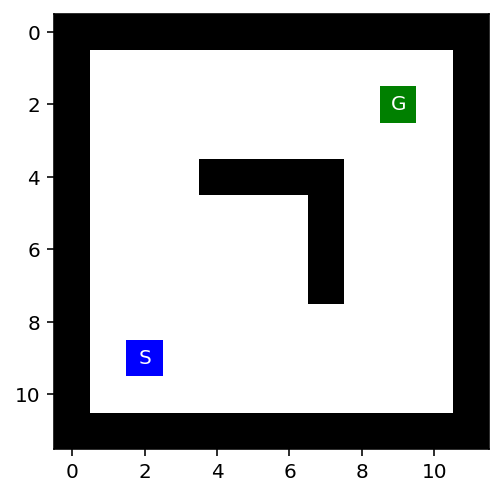

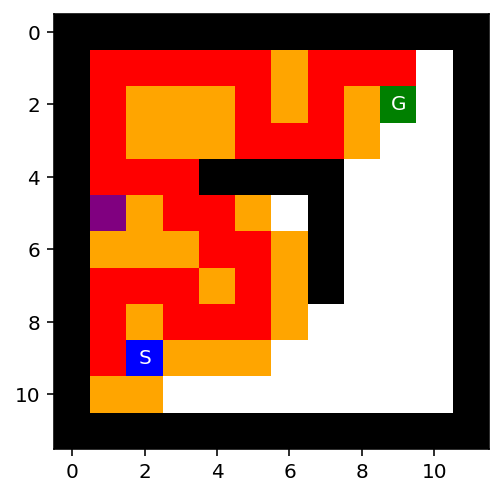

 open_maze.txt
-------------------


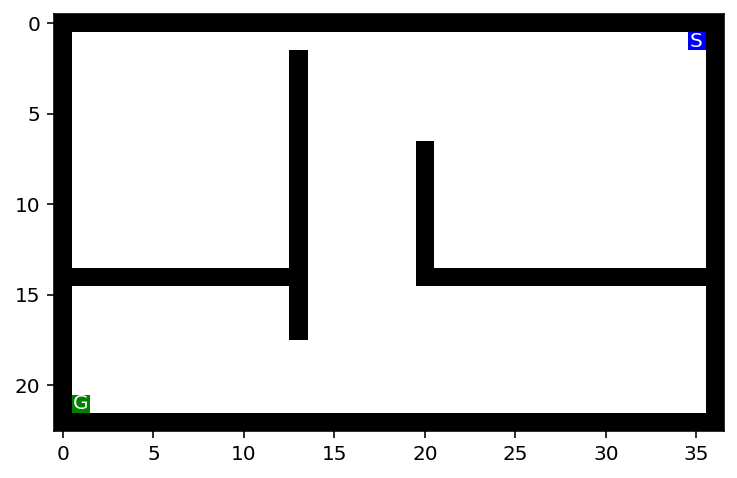

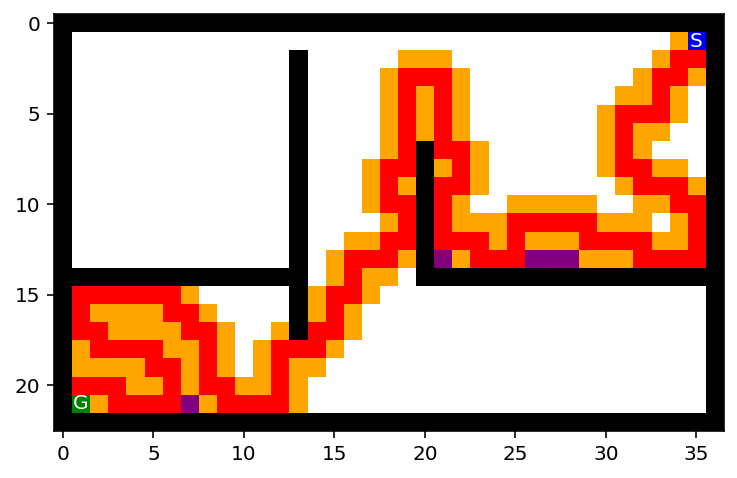

 medium_maze.txt
-------------------


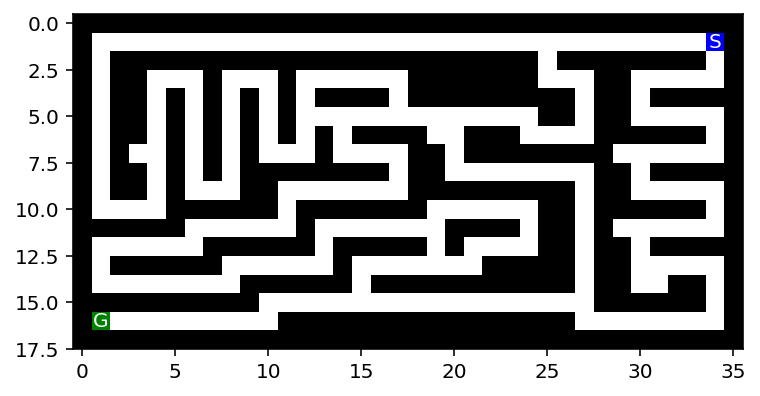

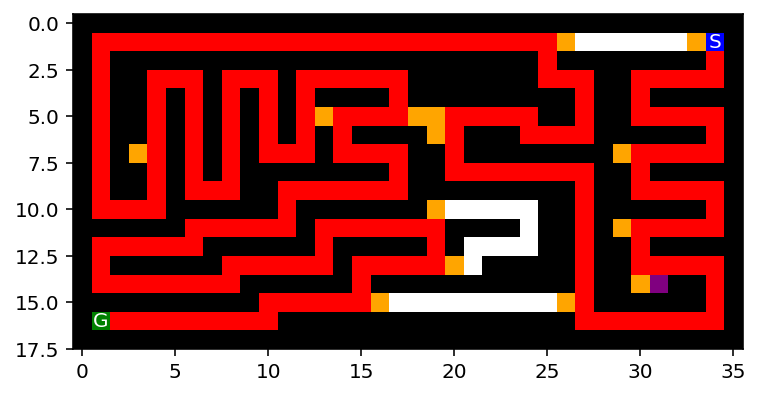

 large_maze.txt
-------------------


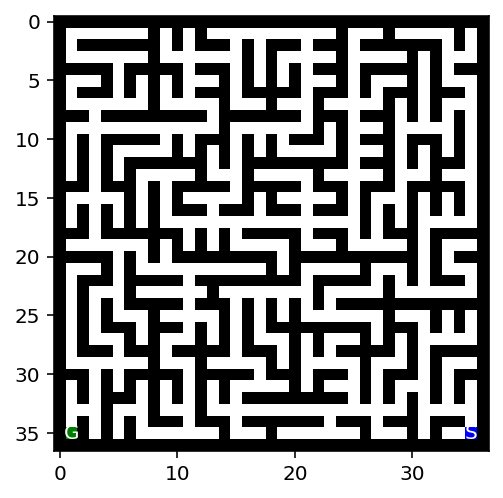

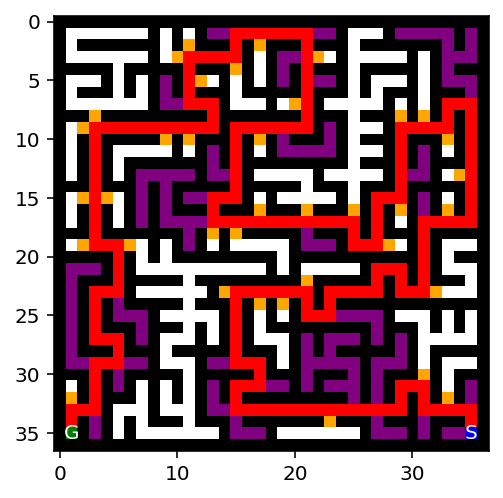

In [14]:
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' {m}\n-------------------')
    show_maze(maze)
    dfs(maze)
    show_maze(maze)  
    f.close()

How do you deal with loops (cycles)?

# Loops Discussion

### Tree implementation

I am not sure how the search tree was supposed to be implemented, so I have simply NOT explicitly costructed a search tree. Originally, I was going to 'Treeify' the entire 2D array to traverse as a traditional search tree, but then opted out because I thought that would simply be extra, unneeded work. I think the 2D array can be interpreted as a tree, and as we 'Nodify' array positions and add them to respective data structures, we can interpret the collection of expanded nodes and frontier nodes as the search tree.

### BFS:

For BFS, it keeps a reached/visited data structure. So it should not expand a node in the reached/visited data structure. 

In my implementaton, visited nodes are saved in a set. BFS only expands nodes on the frontier, so we simply have to avoid adding a visited node back to the frontier. This is rather trivial to do.

### DFS:
For DFS, we don't have a reached/visited collection, but we do have a 'current loop' collection. As we expand nodes, we cannot add nodes to the frontier if they exist on the current loop collection. If there is only one possible node, but it exists in the current_loop, then we mark that as a dead end, and must backtrack.

For backtracking, DFS determines if a node leads to a dead end. If it has reached a dead end, then we remove the node from the current loop collection, and we remove it completely from the tree. Originally I marked the map with 'R' to indicate that it was a removed node. However, after discovering that this approach is not general, and moreso specific to this problem, I had to refactor my approach. My current implementation immediately determines children of nodes as they are added to the frontier. If a node is removed, it is marked as 'None' anywhere that it appears. That means if the removed node was a child of another node on the frontier, it also marked as 'None' there. We no longer try to expand that node ever again. My current implementation is not very great: it just iterates through existing nodes in the frontier to mark the removed node. I would prefer to simply mark a Node as none and have the children pointers point to that so changes are immediately reflected. However, I am not entirely sure how to approach it this way in Python, so if you see this still, that means I did not get to it.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

#### Completion and optimality

BFS is optimal and complete: it always finds the goal state at the optimal cost. Even when its selection of nodes is randomized, the selection of nodes always leads to the best solution outcome.

DFS is complete, but not optimal: it always finds a solution, but it varies with how children nodes are added and selecting which node to expand next. I implemented with random selection of the next node to expand, and you can see the huge variability in how DFS finds solutions, especially in open mazes, where there are plenty of nodes to expand from a given node.

#### BFS time complexity:

As we expand nodes, we search level by level. Searching level by level is what guarantees the optimality of cost on an unweighted graph. So we explore 1 node at first, then $b$ nodes, then $b^2$, then $b^3$, all the way to $b^d$ where d is the depth of the solution and b is in our case, 4, the maximum branching factor. So we have to, at worst, do $b^d$ amount of work.

in terms of nodes in the tree: Time complexity is at worst case: $O(b^d)$

d is the depth of the optimal solution

b is the branching factor. In our case the maximum is 4. But I will leave it as b. See branching factor note.



#### BFS space complexity

Since BFS stores every visited node and frontier node, as we go level by level we store that many nodes. 

Space complexity is at worst case: $O(b^d)$

d is the depth of the optimal solution

b is the branching factor


#### Branching factor
Many nodes on the frontier are shared. We never actually see 4 nodes added to the frontier. So although the theoretical max branching factor for $b$ is 4, the $b$ in our maze is realistically in between 0 and 3. Only one node will ever have 4 children ever, and that is assuming we start at a location near the center with lots of open space. In a more general problem, the branching factor would carry a lot more weight to the complexity of solving the problem, but in this maze example, the branching factor does not add a whole lot complexity.

#### DFS time complexity

DFS may, in the worst case, take the absolute worst route to the solution, where it expands $m$ nodes deep. For example the following maze is a possible path for dfs to take if the algorithm were completely unoptomized and we didnt' check for solutions:

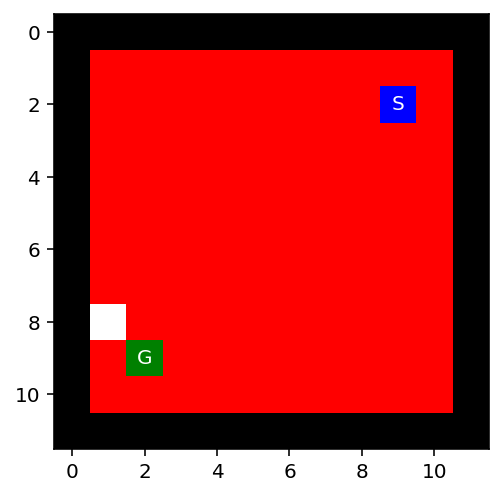

In [16]:
f = open("open_terrible.txt", "r")
maze_str = f.read()
maze = parse_maze(maze_str)
show_maze(maze)

#### DFS complexity (cont)
This would be extremely improbable in a DFS search ( I hardcoded this), and in fact, in our implementation it is impossible to obtain this. But theoretically, this is possible for a poorly optimized DFS. The point here is that DFS may explore the maximum number of nodes it can before it even gets to a solution. In our case, because we check the frontier for duplicates, check the current loop, and remove visited nodes, we don't have as big of an issue; however, we can still obtain pretty terrible solutions with DFS. 

In our tree, if we had $m$ as the deepest node, DFS could possibly explore that deepest node without  getting to the solution, and explore every other branch *but* the solution, before finally getting to the solution. Therefore:

Time complexity: $O(b^m)$

where $m$ is the maximum depth.

Of course, like with BFS, the b is not really 4 in the vast majority of the cases, it ranges from 1 to 3 and the growth is not at all as bad as $O(b^m)$ in the majority of the cases. In fact with these small mazes there aren't  that many branches to choose, especially in the more closed mazes. However, in the theoretical sense, this is worst case for a DFS.

for space complexity, since DFS removes unnecessary paths, it only ever holds the current path taken, which assuming is the worst case, would be $O(bm)$. As we get deeper in the tree, we add b nodes: so if we go to the deepest depth $m$ we add $b$ nodes for each depth factor.

Again, in our case, $b$ is 4, but with many shared frontier nodes, we would actually be using less space.

# Implementation Discussion

### Making Decisions
The order in which child nodes are added into the frontier is important in how both algorithms choose their path. Originally, I decided to return child nodes in a static order. This lead to consistent solutions from both algorithms. BFS always returned the same solution, and it was a very 'L' shaped solution for the open path mazes. When I tried looking at solutions with DFS, however, the solutions I was seeing were very peculiar. They were consistent throughout the mazes, but the solutions would explore unneeded rooms, or it would go through roundabout paths to get to the solution. So to make things interesting, I decided to return child nodes in random order. This lead to BFS open maze solutions to go different paths (although still the same cost), and for DFS to show a variety of different solutions.

**Note**: for DFS, purple squares indicate removed paths
 
 
#### Here are a couple of different solutions from DFS with random children (tested on open_maze.txt):

 open_maze
-------------------


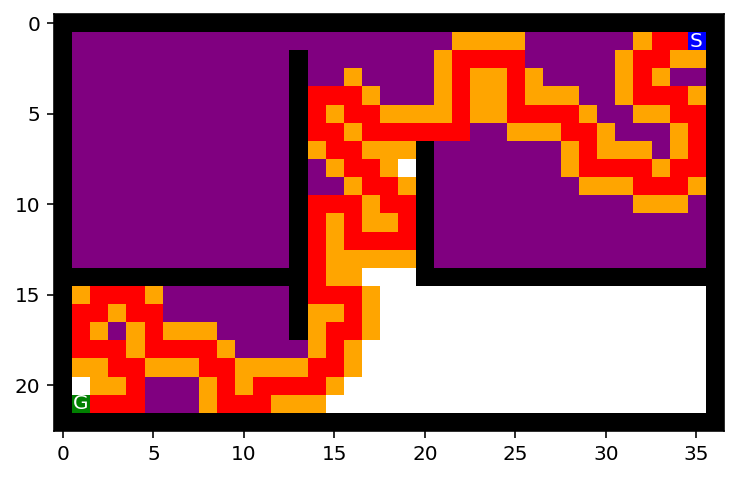

 open_maze
-------------------


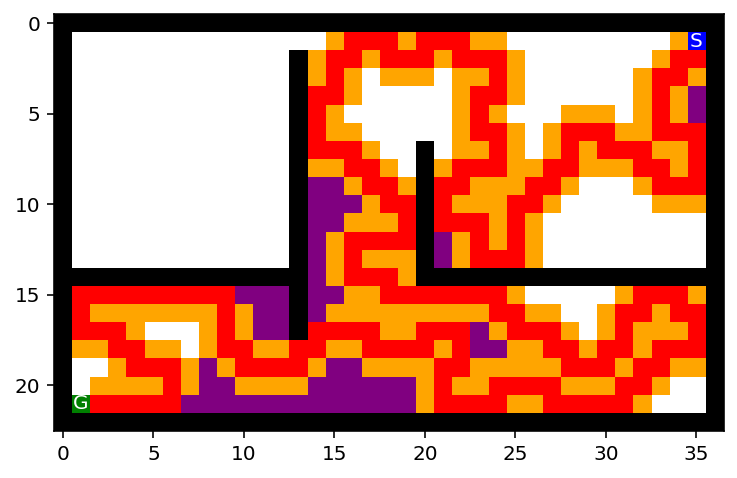

 open_maze
-------------------


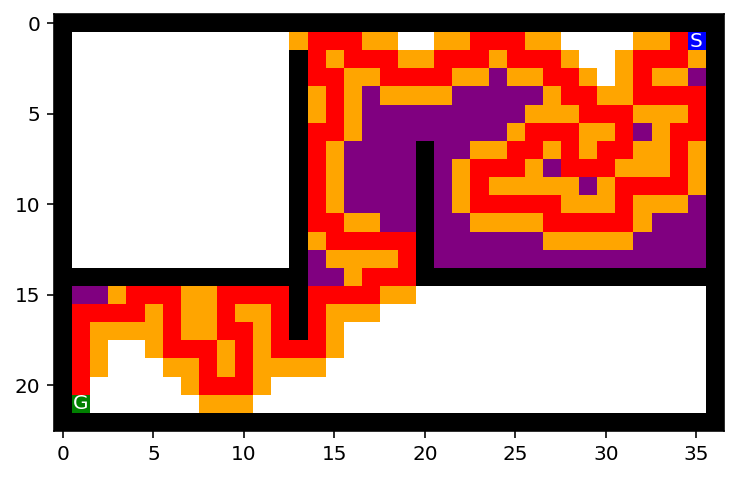

 open_maze
-------------------


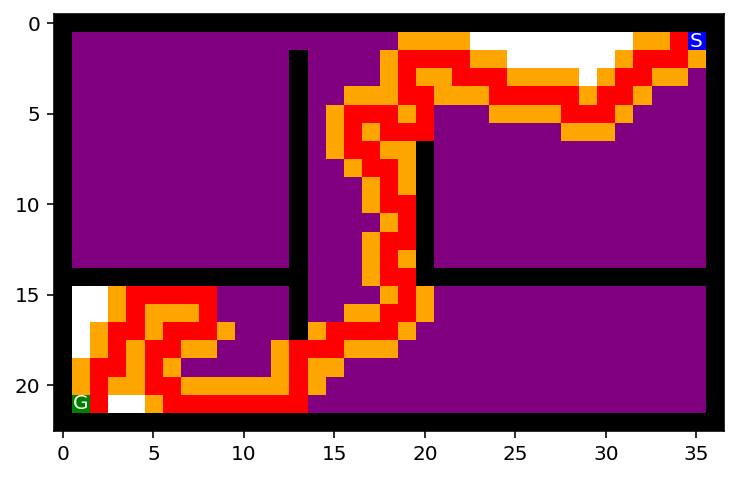

 open_maze
-------------------


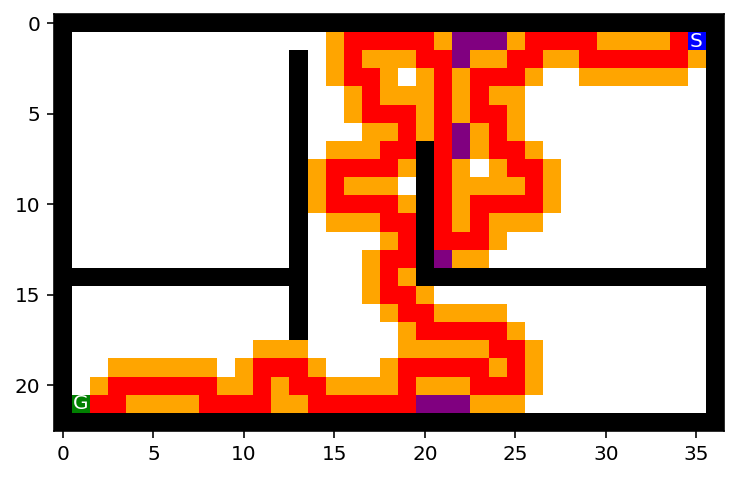

In [17]:
for i in range(1,6):
    f = open("open_maze.txt", "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' open_maze\n-------------------')
    dfs(maze)
    show_maze(maze)  
    f.close()

#### Here are a couple of BFS results with the same maze

 open_maze
-------------------


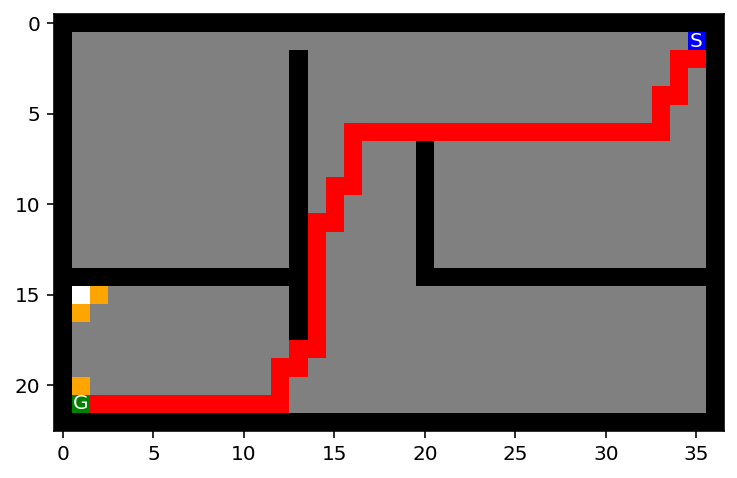

 open_maze
-------------------


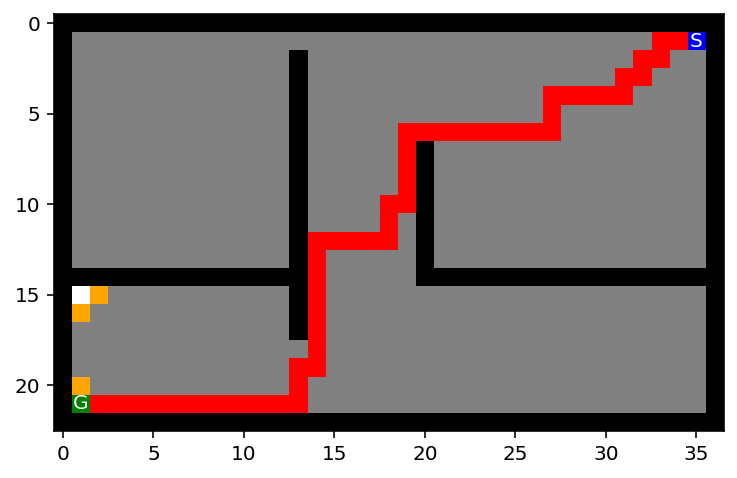

 open_maze
-------------------


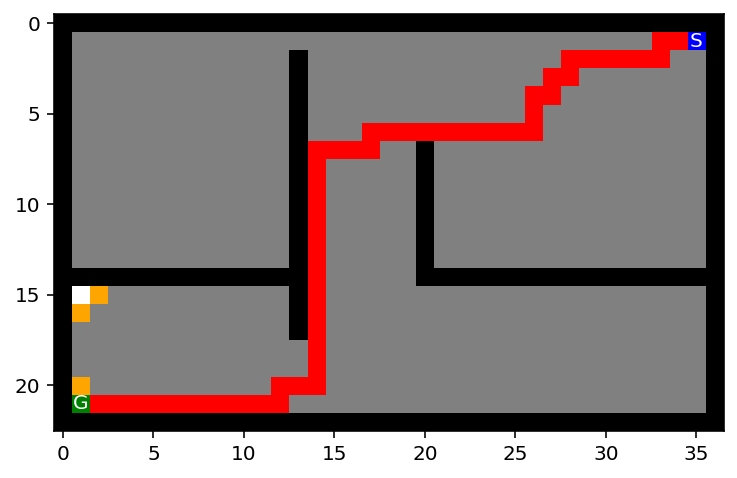

 open_maze
-------------------


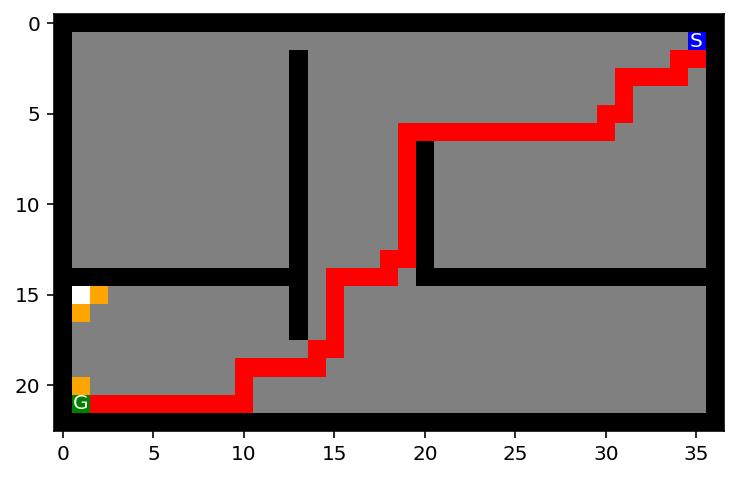

 open_maze
-------------------


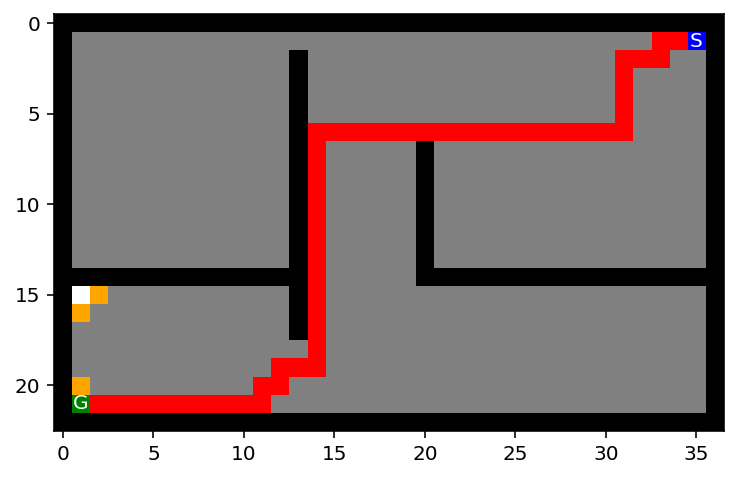

In [18]:
for i in range(1,6):
    f = open("open_maze.txt", "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' open_maze\n-------------------')
    bfs(maze)
    show_maze(maze)  
    f.close()

We can see that for, BFS, we always get the optimal cost. Although the paths may be different, with taxicab geometry, they all cost the same. With DFS, we get completely different results all the time. If there are more decisions to make (i.e. in open areas) DFS suffers a lot because its decision may be completely roundabout and silly. If there are multiple options, DFS is not guaranteed to choose the best option: it just finds an option. BFS on the other hand, always chooses the least-cost option. Therefore we can see that both solutions are complete: they both find answers. However, only BFS is optimal, while DFS is not optimal.

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

In [19]:
# Greedy best-first search
# This is actually used in the class. I just show this here for ease of following the code

def heuristic(current_node, end_goal):
    dist_x = abs(current_node.pos[0] - end_goal[0])
    dist_y = abs(current_node.pos[1] - end_goal[1])
    return dist_x + dist_y


In [20]:
import heapq 

def gbfs(mase, verb=False):
    
    ''' init stuff!!! '''
    start = Node(pos    = find_pos(maze, what = "S"),\
                 parent = None, \
                 action = None, \
                 cost   = 0,
                 node_type = 1)
    final_pos = find_pos(maze, what = "G")
    Node.end_node = final_pos
    frontier = [start] 
    explored = set()
    
    max_frontier = 1
    tree_depth = 0
    max_tree_size = 0
    
    while len(frontier):
        current_node = heapq.heappop(frontier)           # pop from the pqueue frontier
        explored.add(current_node)                       # explore the node
        children = get_node_neighbors(current_node)      # get children/neighbors
        for child in children:
            if not (child in explored ) and not(child in frontier):  
                tree_depth = max(tree_depth, child.depth)
                if child.pos == final_pos:                      # if child is answer get outta here
                    mark_maze(maze, explored, frontier, child)  # maze debugging stuff
                    return (child, child.cost, len(explored), tree_depth, \
                            max_tree_size, max_frontier)
                child.set_type(1)                            # set priority criteria to GBFS
                heapq.heappush(frontier, child)              # push onto the pqueue
                max_tree_size = max(max_tree_size, (len(frontier)) + len(explored) )
                max_frontier = max(max_frontier, len(frontier))
        mark_maze(maze, explored, frontier)
        if verb: show_maze(maze)
        max_frontier = max(max_frontier, len(frontier))
    return None # if no solution

## GBFS Maze Solutions

 empty_maze.txt
-------------------


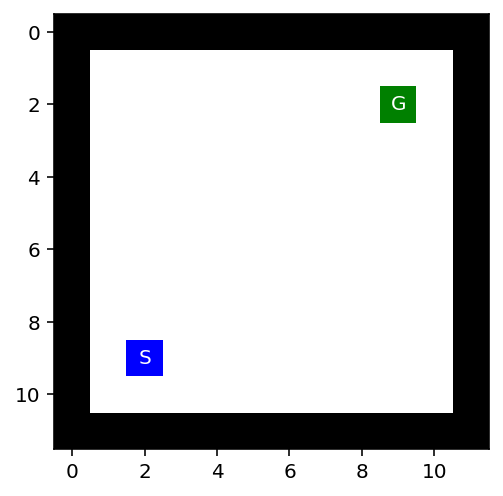

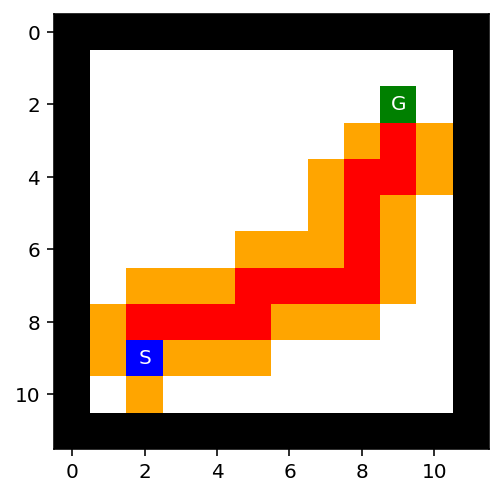

 empty_2_maze.txt
-------------------


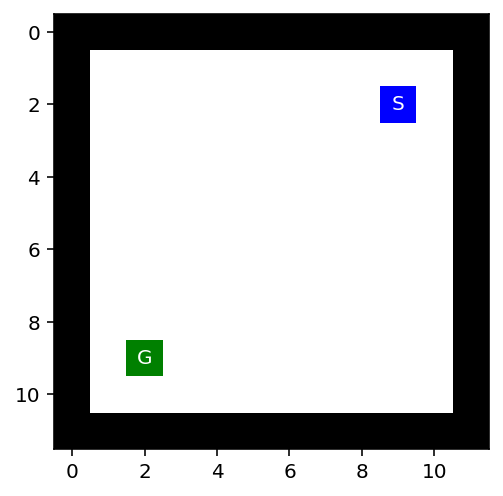

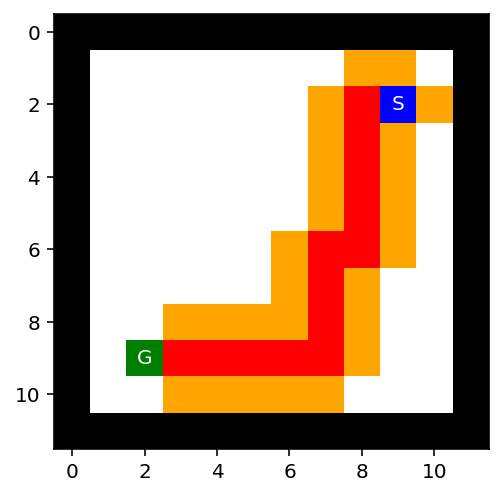

 small_maze.txt
-------------------


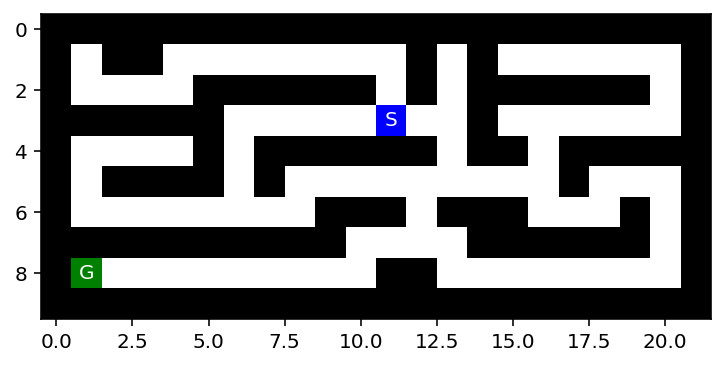

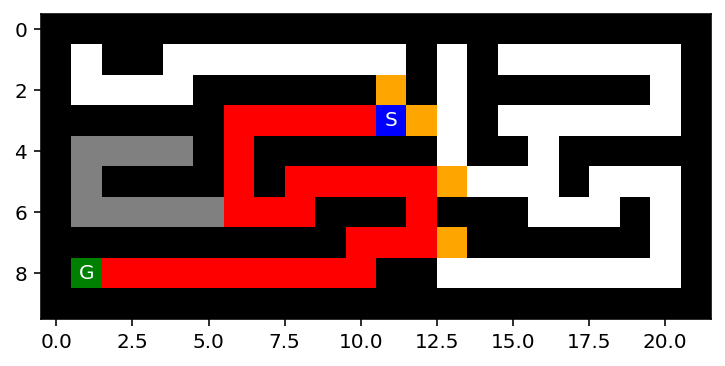

 loops_maze.txt
-------------------


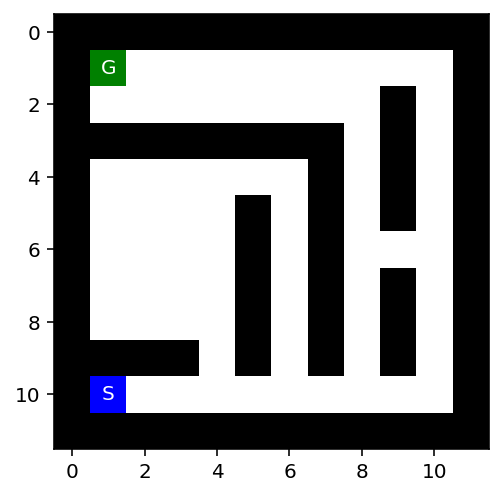

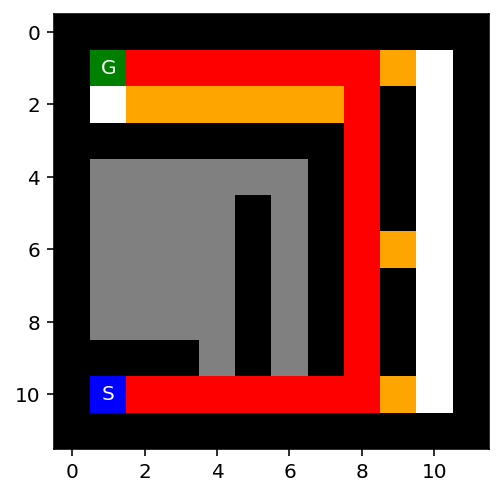

 wall_maze.txt
-------------------


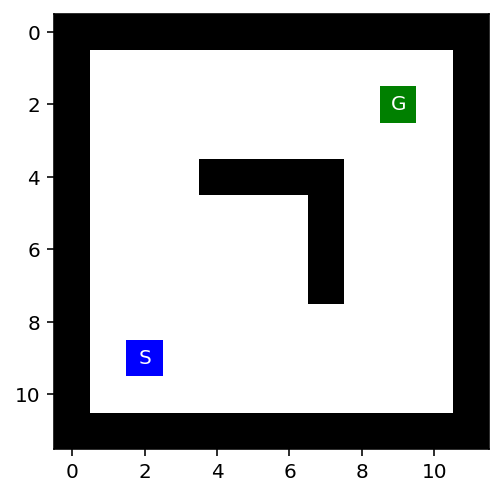

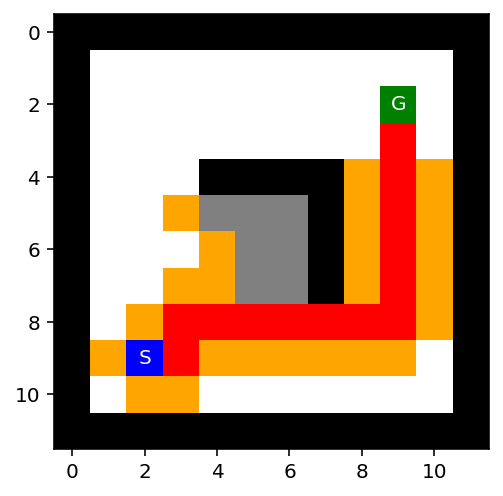

 open_maze.txt
-------------------


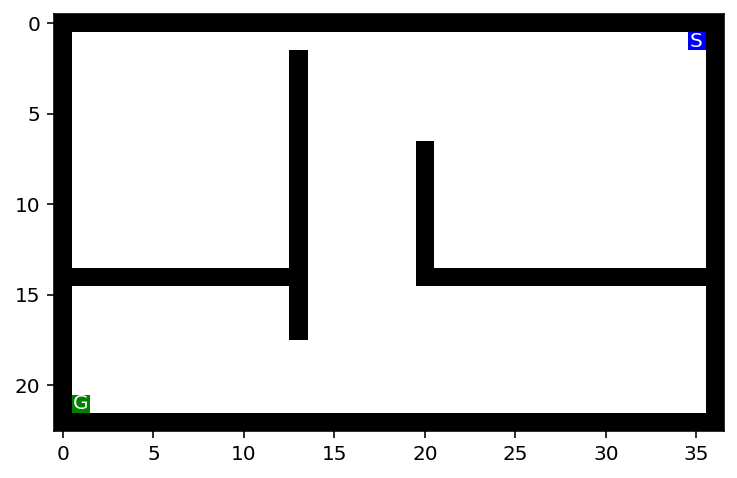

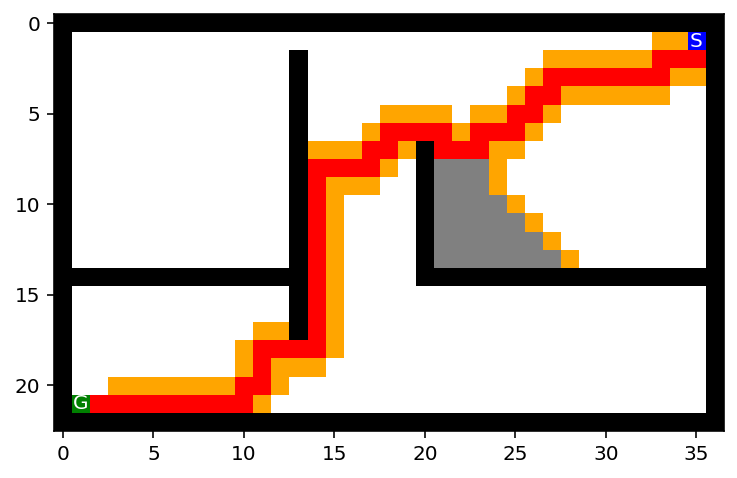

 medium_maze.txt
-------------------


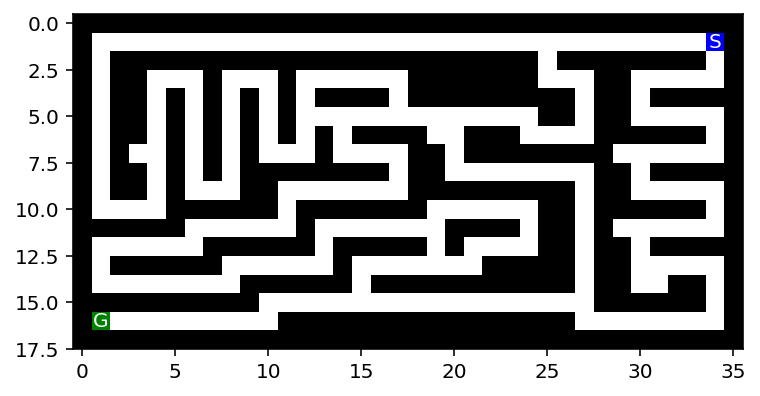

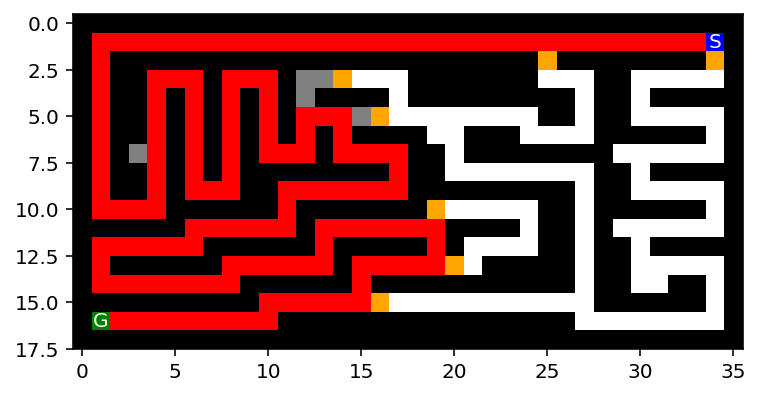

 large_maze.txt
-------------------


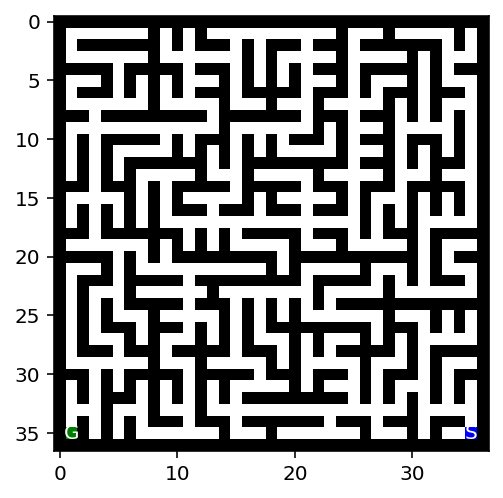

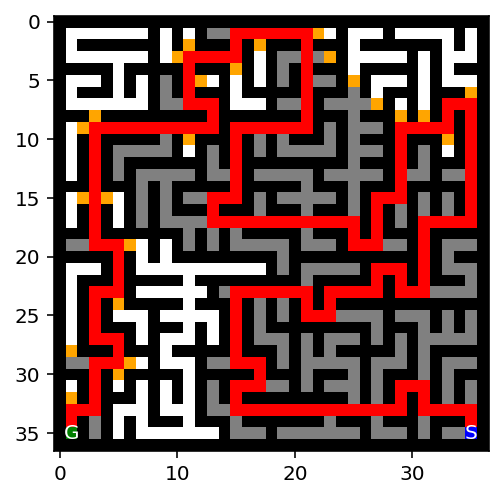

In [21]:
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' {m}\n-------------------')
    show_maze(maze)
    gbfs(maze)
    show_maze(maze)  
    f.close()

In [22]:

def a_star(maze, verb=False):
    
    '''initialization stuff'''
    start = Node(pos    = find_pos(maze, what = "S"),\
                 parent = None, \
                 action = None, \
                 cost   = 0)
    final_pos = find_pos(maze, what = "G")
    Node.end_node = final_pos   # set the static final var as final_pos
    frontier = [start]          # add stuff into p-queue
    explored = set()            # keep track of explored
    
    max_frontier = 1
    tree_depth = 0
    
    while len(frontier):
        current_node = heapq.heappop(frontier)       # pop from priority queue
        explored.add(current_node)                   # explore current node
        children = get_node_neighbors(current_node)  # get neighbors
        for child in children:
            if not (child in explored ) and not(child in frontier):
                tree_depth = max(tree_depth, child.depth)
                if child.pos == final_pos:
                    mark_maze(maze, explored, frontier, child)
                    return (child, child.cost, len(explored), tree_depth, \
                            len(frontier) + len(explored), max_frontier)
                child.set_type(2)                   # this tells the instance that we prioritize using A* criteria
                heapq.heappush(frontier, child)     # pushes onto queue by priority (heuristic + actual cost (depth))
                max_frontier = max(max_frontier, len(frontier))
                
        mark_maze(maze, explored, frontier)
        if verb: show_maze(maze)
    return None # if no solution

## A* Maze Solutions

 empty_maze.txt
-------------------


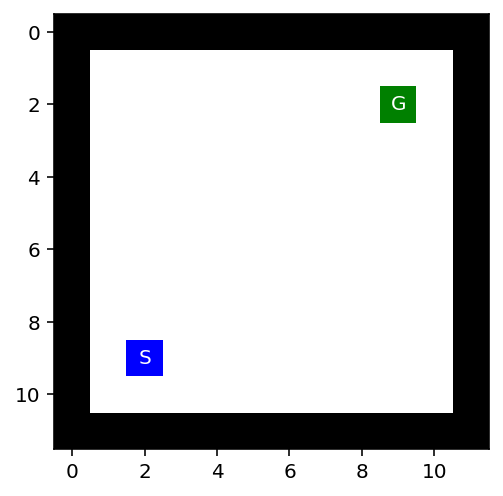

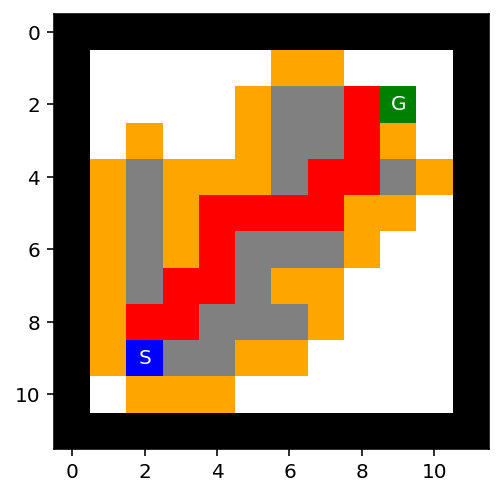

 empty_2_maze.txt
-------------------


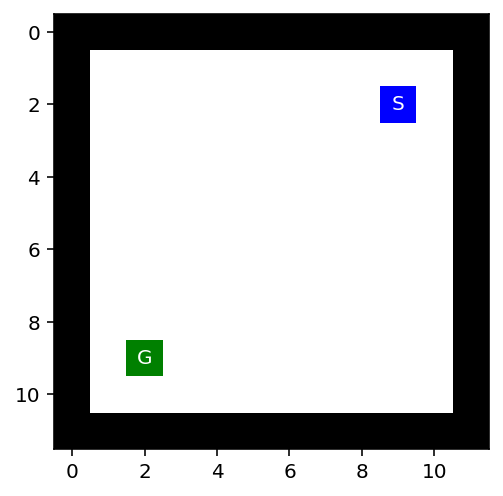

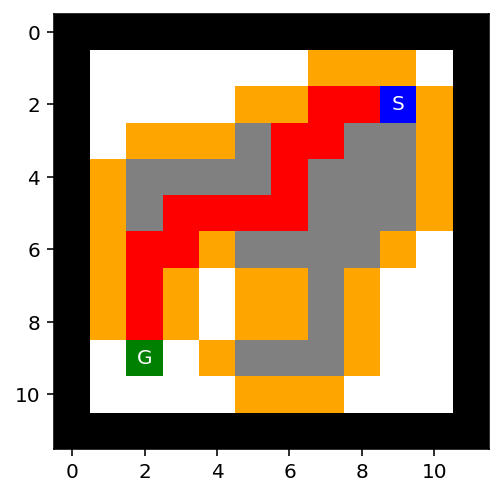

 small_maze.txt
-------------------


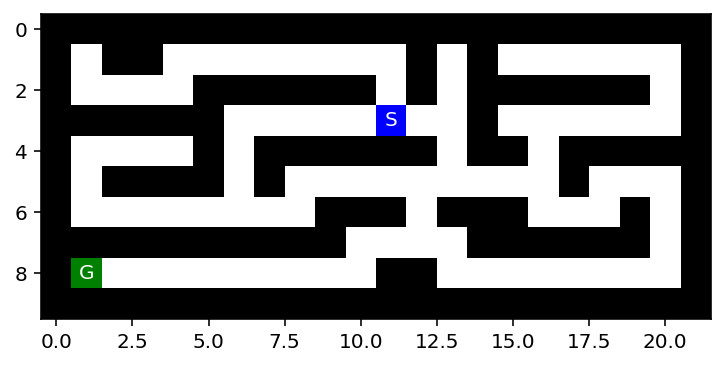

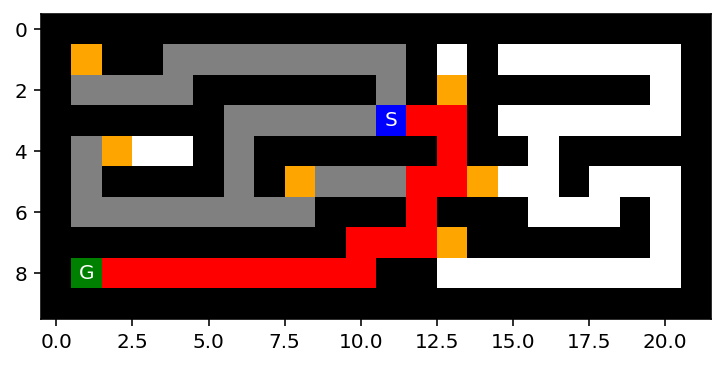

 loops_maze.txt
-------------------


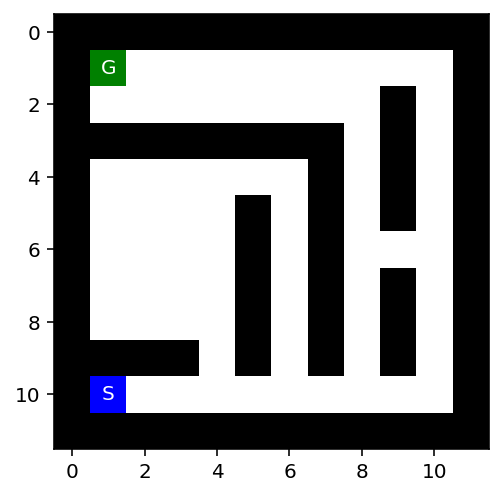

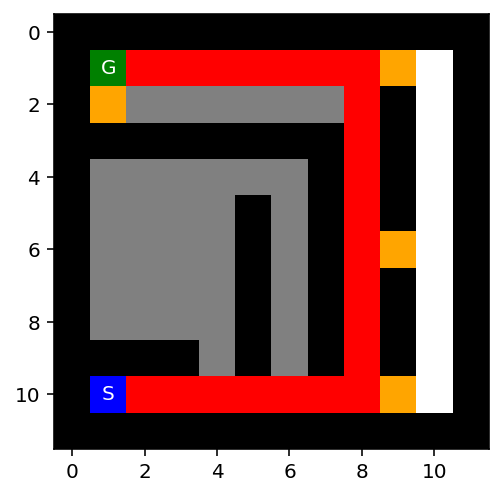

 wall_maze.txt
-------------------


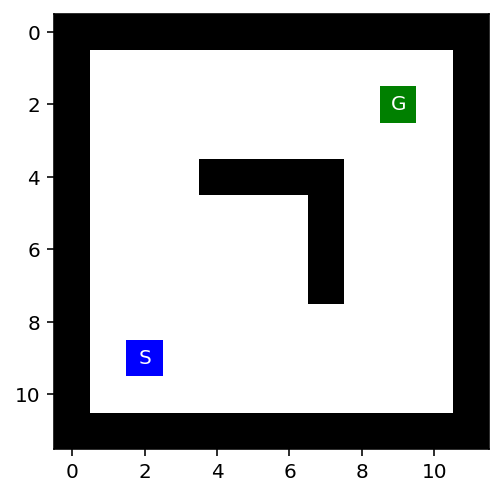

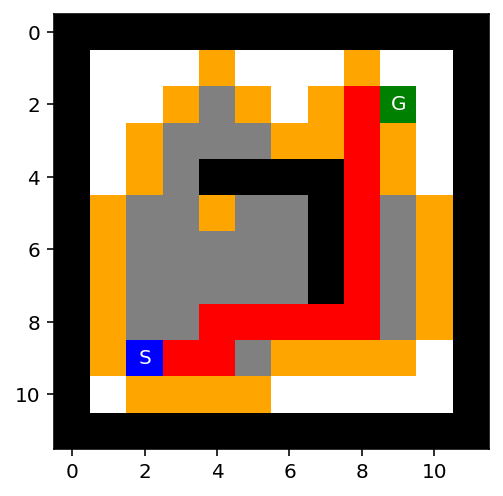

 open_maze.txt
-------------------


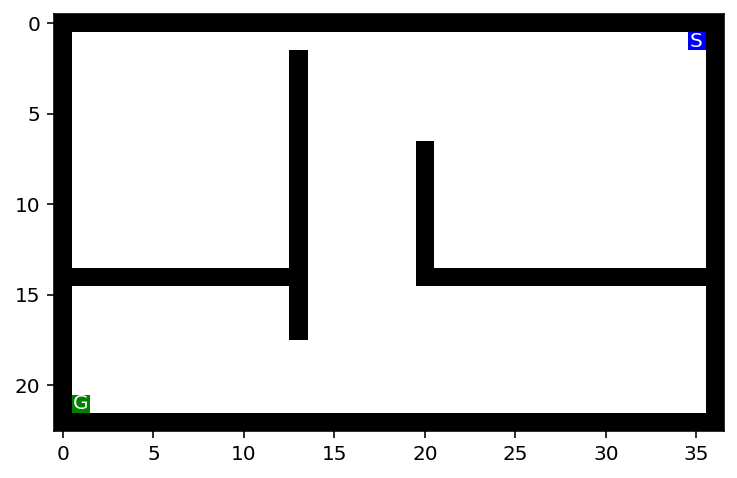

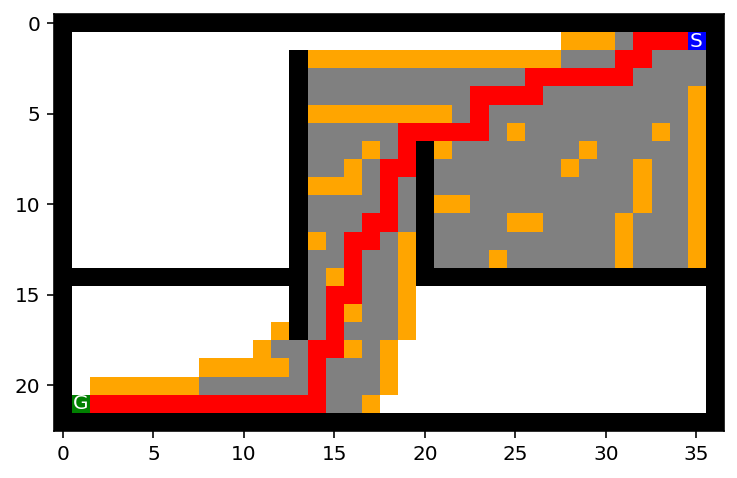

 medium_maze.txt
-------------------


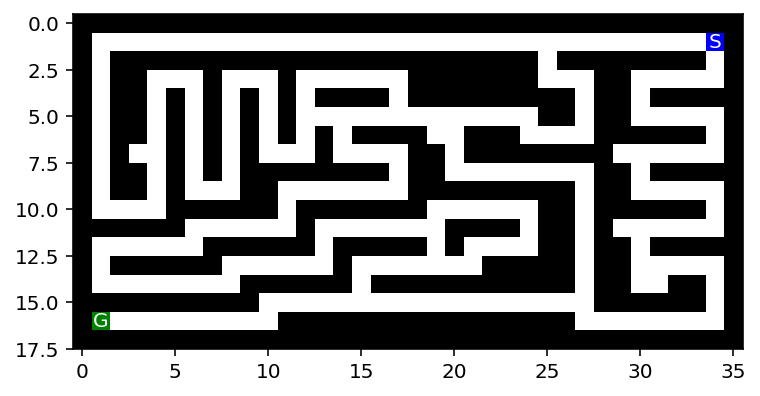

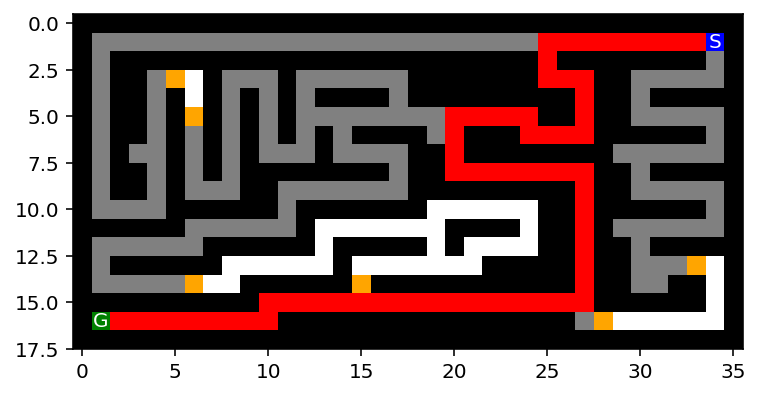

 large_maze.txt
-------------------


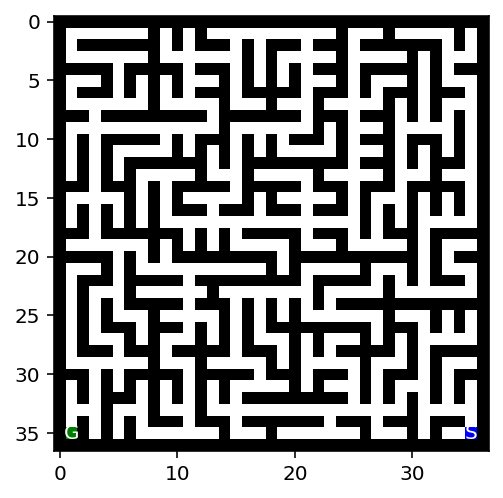

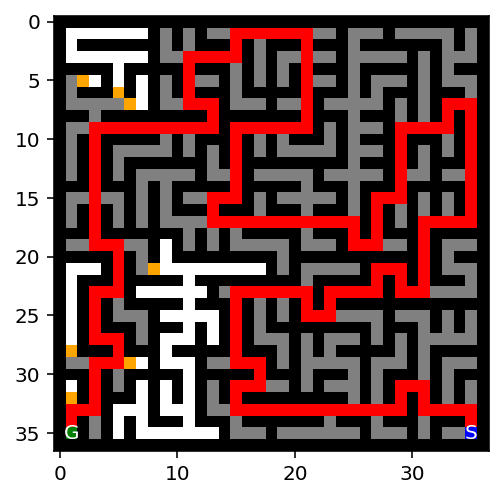

In [23]:
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' {m}\n-------------------')
    show_maze(maze)
    a_star(maze)
    show_maze(maze)  
    f.close()

Are your implementations complete and optimal? What is the time and space complexity?

# Discussion


## Implementation
Both my A* and GBFS are essentially the same, with GBFS striclty using the heuristic and A* using both the heuristic and cost.


Both A* and GBFS are complete. We can reach a solution with either solution.

However, GBFS is not optimal. Because the heuristic value is the sole deciding factor in choosing a path, and because mazes are not always open, heuristics on their own may make for a bad decision. For example, in the medium maze, GBFS really wants to go left or down from the starting position. However, the maze does not allow for left or down movements directly to the answer.

GBFS time complexity: $O(b^m)$

GBFS space complexity $O(b^m$

A* is optimal. In this case, it uses the admissible heuristic manhattan distance function as well as takes into account the actual cost of the nodes. This leads to picking the optimal solution

A* time complexity: $O(b^d)$

A* space complexity: $O(b^d)$

Where $d$ is the depth of soln

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts.

In [24]:
import numpy as np
import pandas as pd

empty_dfs = lambda n : [None for _ in range(n)]

sm_df, med_df, em1_df, em2_df, lp_df, wl_df, op_df, lg_df = empty_dfs(8)

data = [[sm_df, 'small_maze.txt'],
        [med_df,'medium_maze.txt'],
        [em1_df,'empty_maze.txt'],
        [em2_df,'empty_2_maze.txt'],
        [lp_df,'loops_maze.txt'],
        [wl_df,'wall_maze.txt'],
        [op_df,'open_maze.txt'],
        [lg_df,'large_maze.txt']
       ]
for df in data:  
    maze_data =[]
    for algo in [(dfs,'DFS'), (bfs,'BFS'), (gbfs,'GBFS'), (a_star,'A*')]:
        algo_data = np.array([0]*5)
        for _ in range(100):
            f = open(df[1], "r")
            maze_str = f.read()
            maze = parse_maze(maze_str)
            ls_data = list(algo[0](maze))
            res = np.array(ls_data[1:])
            algo_data = np.sum([algo_data, res], axis=0)
        algo_data = np.divide(algo_data, 100).tolist()
        algo_data.insert(0,algo[1])
        maze_data.append(algo_data)
    df[0] = pd.DataFrame(maze_data, columns =['Algo', 'Path Cost','Nodes expanded', 'Max Tree Depth', 'Max Tree Size', 'Max Frontier Size'])
            
            

# Mazes Performance
The results are the average results over 100 runs

### Small Maze

In [25]:
print(data[0][1])
data[0][0]

small_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,35.58,40.18,39.91,44.66,6.07
1,BFS,19.00,89.98,19.00,91.50,8.74
2,GBFS,29.00,39.00,29.00,43.00,5.00
3,A*,19.00,52.00,19.00,58.00,8.00


### Medium Maze

In [26]:
print(data[1][1])
data[1][0]

medium_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,122.98,171.28,170.70,179.74,10.07
1,BFS,68.00,266.55,68.00,269.03,8.24
2,GBFS,110.66,115.69,110.66,120.57,5.88
3,A*,68.00,221.00,68.00,227.00,8.00


### Empty Maze

In [27]:
print(data[2][1])
data[2][0]

empty_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,25.94,26.88,26.73,55.21,28.95
1,BFS,14.00,91.66,14.00,94.84,12.00
2,GBFS,14.00,14.00,14.00,36.35,22.73
3,A*,14.00,38.67,14.00,70.13,32.60


### Empty Maze 2

In [28]:
print(data[3][1])
data[3][0]

empty_2_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,25.74,27.92,27.67,56.35,29.26
1,BFS,14.00,91.60,14.00,94.81,12.00
2,GBFS,14.00,14.00,14.00,36.48,22.77
3,A*,14.00,38.78,14.00,70.51,33.07


### Loops Maze

In [29]:
print(data[4][1])
data[4][0]

loops_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,36.98,37.28,37.18,48.98,13.00
1,BFS,23.00,70.00,23.00,71.00,7.90
2,GBFS,23.00,51.00,23.00,59.03,9.02
3,A*,23.00,57.00,23.00,61.00,7.41


### Wall Maze

In [30]:
print(data[5][1])
data[5][0]

wall_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,25.42,26.51,26.41,50.13,24.19
1,BFS,14.00,84.91,14.00,87.92,9.75
2,GBFS,15.24,19.39,15.24,42.29,23.24
3,A*,14.00,41.91,14.00,71.42,30.27


### Open Maze

In [31]:
print(data[6][1])
data[6][0]

open_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,125.80,141.93,141.26,283.49,142.73
1,BFS,54.00,679.22,54.00,682.11,25.00
2,GBFS,64.84,84.34,64.84,156.47,72.66
3,A*,54.00,272.91,54.00,355.03,85.90


### Large Maze

In [32]:
print(data[7][1])
data[7][0]

large_maze.txt


,Algo,Path Cost,Nodes expanded,Max Tree Depth,Max Tree Size,Max Frontier Size
0,DFS,210.0,218.14,217.24,251.83,35.19
1,BFS,210.0,617.39,210.00,620.39,8.39
2,GBFS,210.0,458.86,210.00,480.78,22.92
3,A*,210.0,549.00,210.00,556.00,12.34


## Results Discussion

* As expected BFS and A* both consistently give the same result: the optimal solution to solving the mazes, while GBFS and DFS both varied in their solutions, giving a variety of solutions, depending on the layout of the maze, and positions of the start and end states.

* The max tree depth was consistently higher for DFS, which makes sense: it is a *depth* first search.

* One notable thing that I did not expect was that the max tree size for GBFS was less than than expected -- sometimes even less than DFS with the memory optimization. But after some thought, this makes sense: GBFS is so greedy to take the heuristic that it tries to expand the least amount of nodes that it can as it tries to take the Greedy way. For many of these mazes, it does not prove to be too costly with respect to the tree size. The best case for GBFS is $O(bd)$ afterall, and we can see this best case scenario with the empty mazes, and a not-so-bad approach for any of the mazes with openness.

* BFS Consistently expanded the most nodes, and had the highest max tree size in all problems. Again, this is to be expected because this is an uninformed search, and we just keep expanding the nodes on the frontier. This leads to growing a large tree.

Discuss the most important lessons you have learned from implementing the different search strategies. 

# discussion
One of the most important lessons I learned with this assignment was the power of randomness, specifically for DFS in this assignment, but I was also able to take away that many general approaches to problems may benefit from using randomness  as well. Often times we might think that some sort of structure and consistency leads to a better solution, but that is definitely not the case in this instance. As you showed in class, and as I played around in this assignment, we saw that randomness was often just a better solution than having consistent directions that lead to consistently bad solutions.

Also, taking into account memory efficiency vs time efficiency. Often we may prefer a more time-efficient algorithm over a memory-efficient algorithm: in most applications time is more valuable than memory. However, this cannot be said for A.I. applications. Since a lot of these problems may deal with LARGE space or even infinite spaces, it is better to use the memory more wisely than the time.

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

In [33]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [34]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [35]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [36]:
# Your code/answer goes here